### A RNN model for Representational Drift Driven Through Synaptic Volatility

#### Import

In [2]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))

%load_ext autoreload
%autoreload 2

from helper_functions.shared_env import *

print("Environment and libraries loaded successfully.")
print("Libraries loaded successfully.")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Environment and libraries loaded successfully.
Libraries loaded successfully.


# Setup

### Model Parameter

In [3]:
#Network parameters
N = 50 # Number of neurons

#Inhibition parameters
I0 = 5
I1 = 1
I2 = .05

#Time constants
taur = 50 #firing rate decay
tauw = 1000 #synaptic weight learning rate
tautheta = 800 # threshold adaptation rate
decay = 1000 #weight decay time constant

#Initial conditions
y0 = 10 
r0 = np.zeros(N) #initial firing rates
w0 = np.zeros(N * N) # initial weights
theta0 = np.zeros(N) # initial thresholds

#Simulation parameters
nstep = 13000 #Total number of time steps
dt = 1 # time step size

#Stimulus parameters
IN = 15 # input amplitude
Nstim = 10 # number of stimulation pulses per day
stim = 200 # duration of each stimulation pulse (includes the gap imediately after)
duration = 100 # duration of gap between stimulation pulses (so increasing this shortens the actual pulse duration) [default 100ms]
pause = 1000 # duration of pause before stimulation starts
delay = 3000 # delay between day starts (so the actual gap is delay - (Nstim * stim) [default 1000ms])
Nevent = 4 # number of stimulation days 

#Volatility parameters
vol_mean = 0 # mean of volatility noise
vol_std = 0.02 # standard deviation of volatility noise

#exctiability parameters
exc0 = 0 # clamp no change
Emat = np.zeros((N,nstep))

#Experiment parameters
Nseed = 1 # number of different random seeds for simulations

print("Parameters set successfully.")

Parameters set successfully.


### Input Sequence

#### Generate Input Sequence

The input array, $seq[ ]$, consists of two times for each pulse, start time and a end time.

In [4]:
#Constructing the stimulus sequence
seq = []
for ev in range(Nevent):
    for i in range(Nstim):
        # Adding print statements for debugging
        # print(ev, i)
        # print(pause,' + ', i*stim, ' + ', delay*ev)
        # print(pause + i*stim + delay*ev)
        # print(pause,' + ', i*stim,' + ', duration, ' + ', delay*ev)
        # print(pause + i*stim + duration + delay*ev)
        # print("==================")
        seq.append(pause + i*stim + delay*ev)
        seq.append(pause + i*stim + duration + delay*ev)
def INPUT(t):
    L = 0
    pol = 1
    for step in seq:
        L += np.tanh(t-step)*pol
        pol *= -1
    return IN * np.ones(N)*L/2 + 1
    
index = [range(0,N),
         range(N,N + N*N),
         range(N + N*N,N + N*N +N),
         range(N + N*N +N,N + N*N+N+N),
         range(N + N*N +N+N,N + N*N +N+N+N),
         range(N + N*N +N+N+N,N + N*N +N+N+N+1),
         range(N + N*N +N+N+N+1,N + N*N +N+N+N+1+1)]

day_timesteps = []
day_timesteps.append(0)
for ev in range(Nevent):
        #day_timesteps.append(int(pause + delay*(ev+0.5)+Nstim*stim*0.5)) # the explanation for this is pretty complicated but drawn out in my notes
        day_timesteps.append(int((pause + delay*ev + Nstim*stim)))
print(day_timesteps)

[0, 3000, 6000, 9000, 12000]


#### Visualise Input Sequence

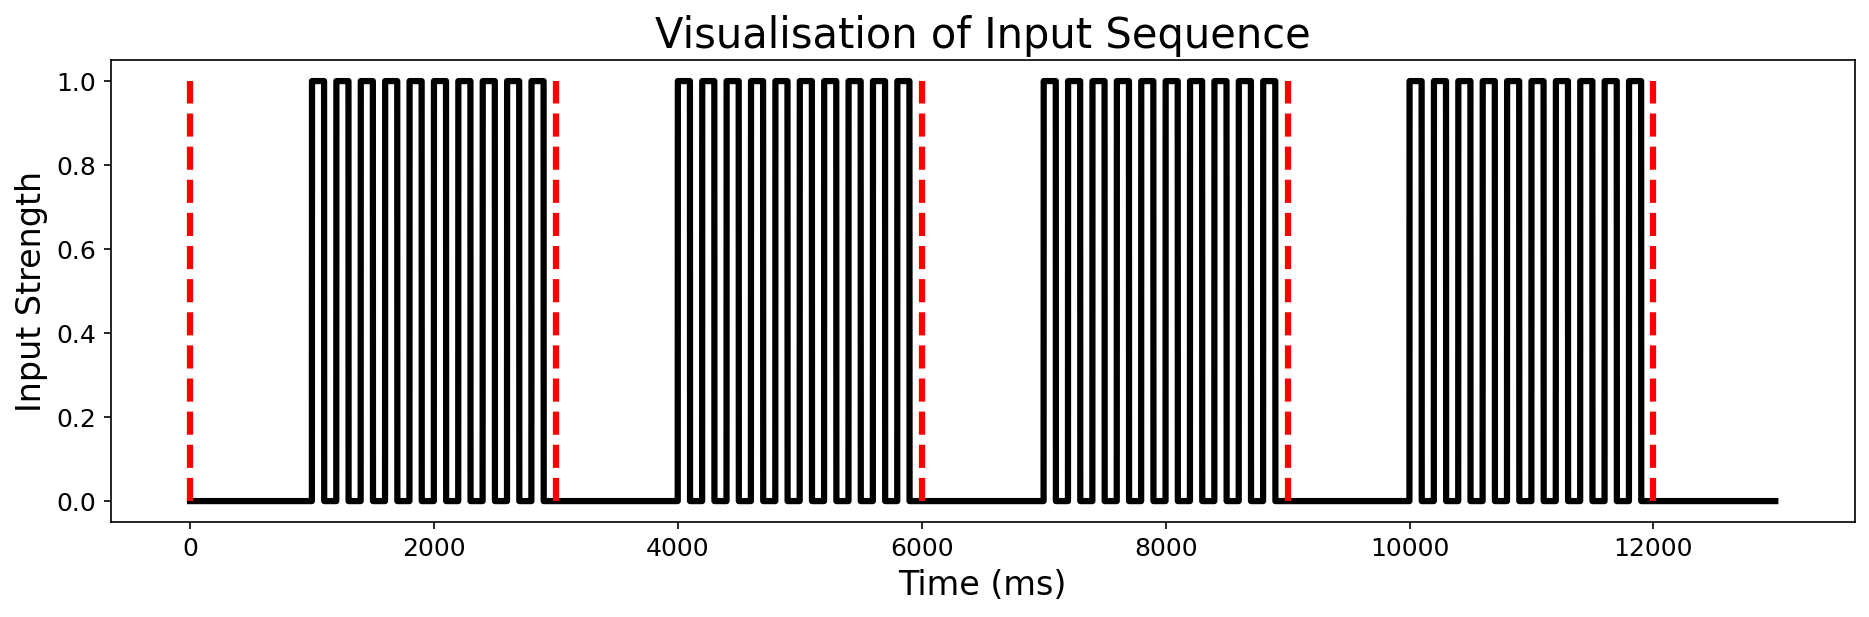

In [5]:
%matplotlib inline

#Visualising the input sequence
visualise_inputs(**locals())

# Main Loop

### Update Function

Implement the main update function across the network.
<br>
Spike Updates <br>
Inhibition current (Eq. 1):
$$
r_{inhib} = I_0 + I_1 \cdot \sum_{i = 0}{r_i} + I_2 \cdot \sum_{i = 0}{r_i^2}
$$
Firing rate equation (Eq. 2): 
$$
\frac{dr}{dt} = (-r + \phi[w \cdot r + I_{ext}(t) - I_{inhib}])
$$

Theta Updates <br>
Theta equation (Eq. 3):
$$
\frac{d\theta}{dt} = \frac{\frac{r}{y_0} - \theta}{\tau_\theta}
$$

Weight Updates <br>
Weight Equation (Eq. 4):
$$
\frac{dw}{dt} = \frac{ \sum{r_i \times r_j}}{\tau_w} - \frac{w}{decay} + \sigma
$$
(clamped between 1 and 0)

Excitability Updates <br>
Excitability Equation (Eq. 4):
$$
\frac{dE}{dt} = 0
$$
(follows Emat not time evolution)

In [6]:
def f(yt,t,tag,dt):
    # define values
    global theta
    r = yt[index[0]][np.newaxis].T # Index 0: firing rates
    r = r*(r>1e-5) # say its zero if its very small

    W = yt[index[1]].reshape((N,N)) # Index 1: synaptic weights


    theta = yt[index[3]][np.newaxis].T # Index 3: thresholds

    #inhibition equation (Eq. 1)
    rinhib = I0 + np.sum(r)*I1 + np.sum(np.multiply(np.maximum(0,r),r))*I2

    #firing rate evolution (Eq. 2)
    drdt = (-r + np.maximum(0,W.dot(r) + INPUT(t)[np.newaxis].T - rinhib ) )/taur

    #theta evolution (Eq. 3)
    dthetadt = np.zeros(N)
    dthetadt = ( r/y0 - theta ) / tautheta

    #weight evolution (Eq. 4)
    dWdt = r.dot(r.T) / tauw - W/decay + np.random.normal(vol_mean,vol_std,(N,N))
    
    #dWdt = np.tanh(r.dot((r-0).T)) / tauw - W/decay
    dWdt = np.multiply(dWdt,np.logical_not(np.logical_or(np.logical_and(W>=1,dWdt>0),np.logical_and(W<=0,dWdt<0))))
    #drdt = np.multiply(drdt,np.logical_not(np.logical_or(np.logical_and(r>=10,drdt>0),np.logical_and(r<=0,drdt<0))))

    #excitation evolution
    dexcdt = np.zeros(N)

    
    #reshape y
    dydt = np.concatenate((drdt.flatten(),
                           dWdt.reshape((N*N)).flatten(),
                           dexcdt.flatten(),
                           dthetadt.flatten()))

    return dydt

### Run Function

Update the state matrix paramters according to the Euler Method:
$$\mathbf{y}_{n+1} = \mathbf{y}_n + \Delta t \cdot f(\mathbf{y}_n, t_n, \text{tag}, \Delta t)$$

$\mathbf{y}_{n+1}$ => New state matrix at $t + 1$ <br>
$\mathbf{y}_n$ => Current state matrix at $t$ <br>
$\Delta t$ => Timescale of each system update <br>
$t_n$ => Current timestep of the model <br>
$tag$ => Currently redundant <br>


In [7]:
def run(INPUT):
    global theta
    theta = 0
    global step
    step = 0
    tag = 0
    thetaL = np.zeros((N,1))
    y0 = np.concatenate((r0,w0,exc0,theta0))
    y = np.zeros((len(y0), nstep)) #y is a complete description of the enviroment of all time
    y[:,0] = y0
    for step in range(nstep-1):
        y[:,step+1] = (y[:,step] + dt * f(y[:,step],dt*step,tag,dt)[np.newaxis]);
    return y

### Multi-Seed Experiment loop

  0%|          | 0/20 [00:00<?, ?it/s]

carrying out seed 0


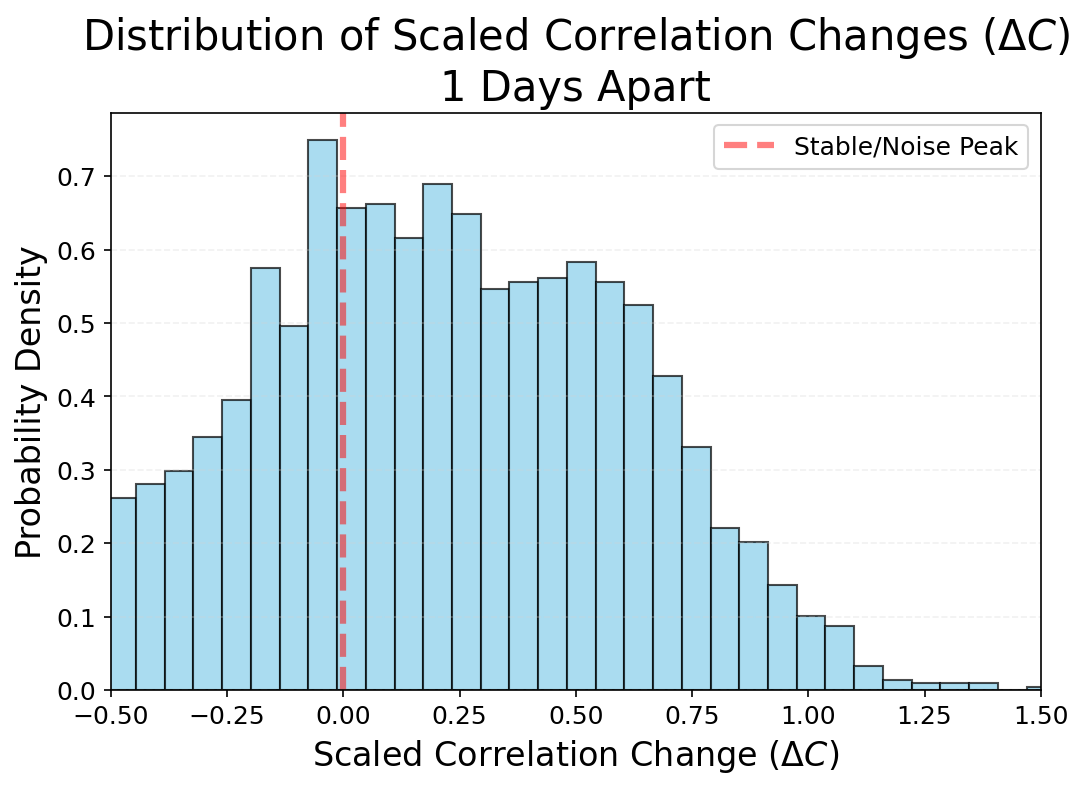

  5%|▌         | 1/20 [00:05<01:49,  5.75s/it]

carrying out seed 1


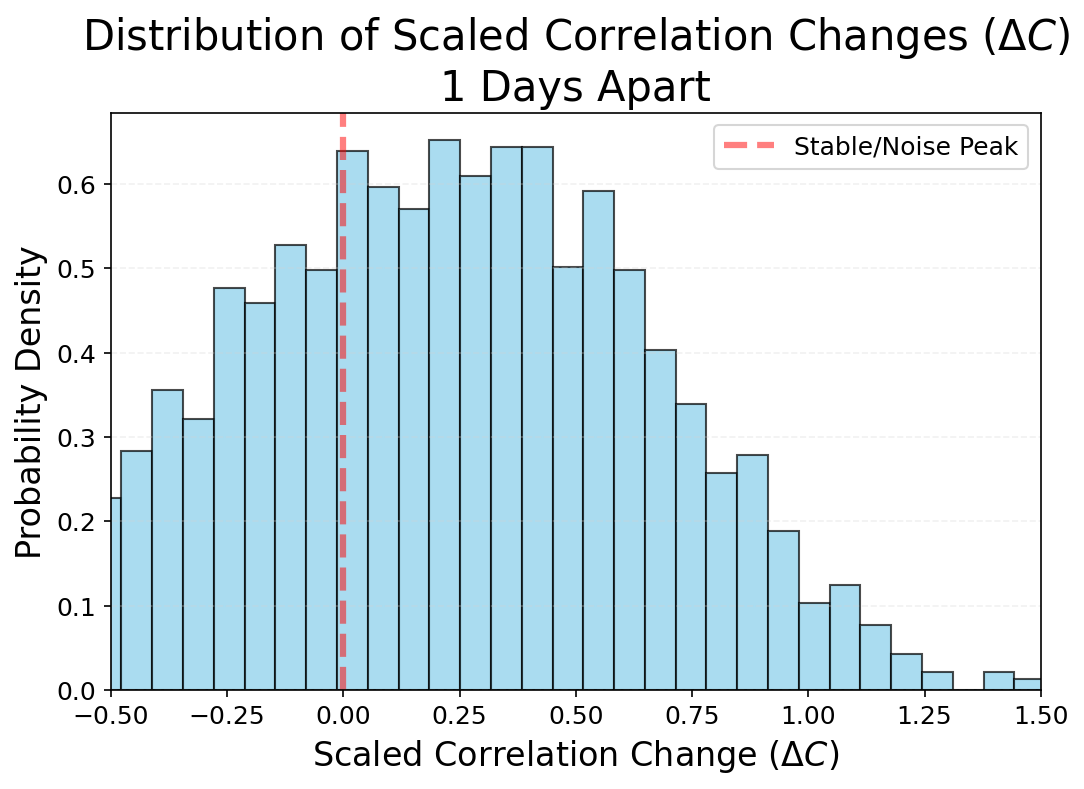

 10%|█         | 2/20 [00:11<01:43,  5.77s/it]

carrying out seed 2


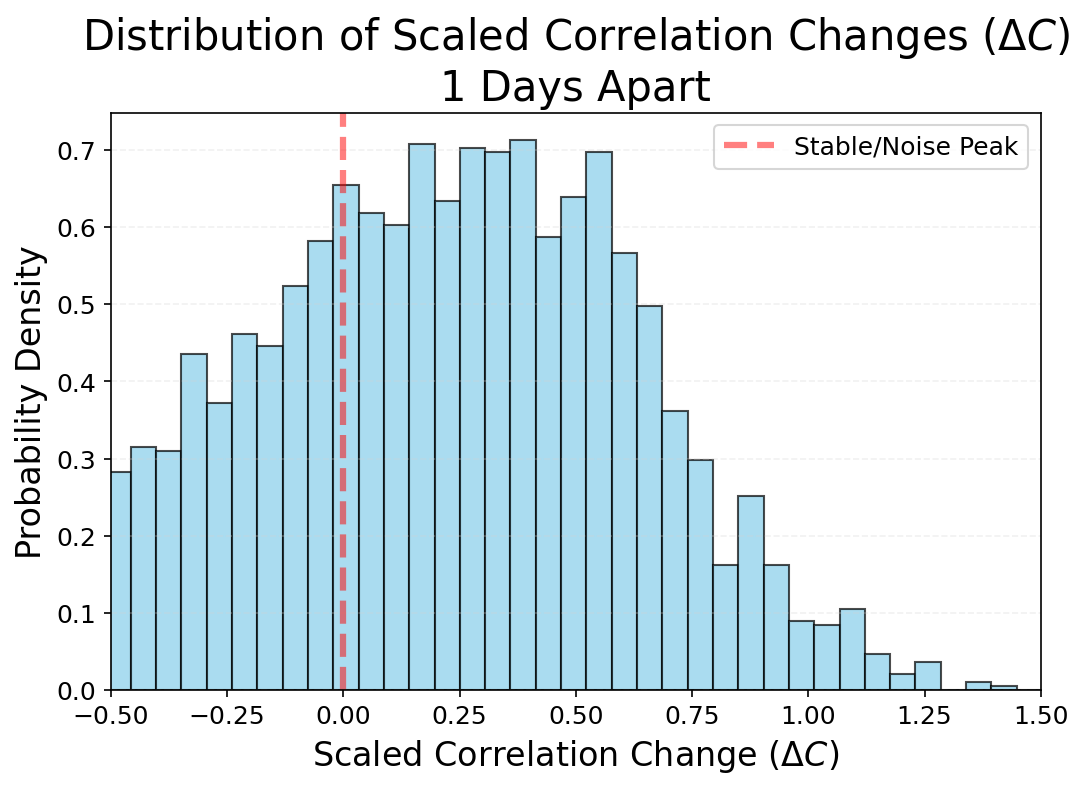

 15%|█▌        | 3/20 [00:17<01:40,  5.92s/it]

carrying out seed 3


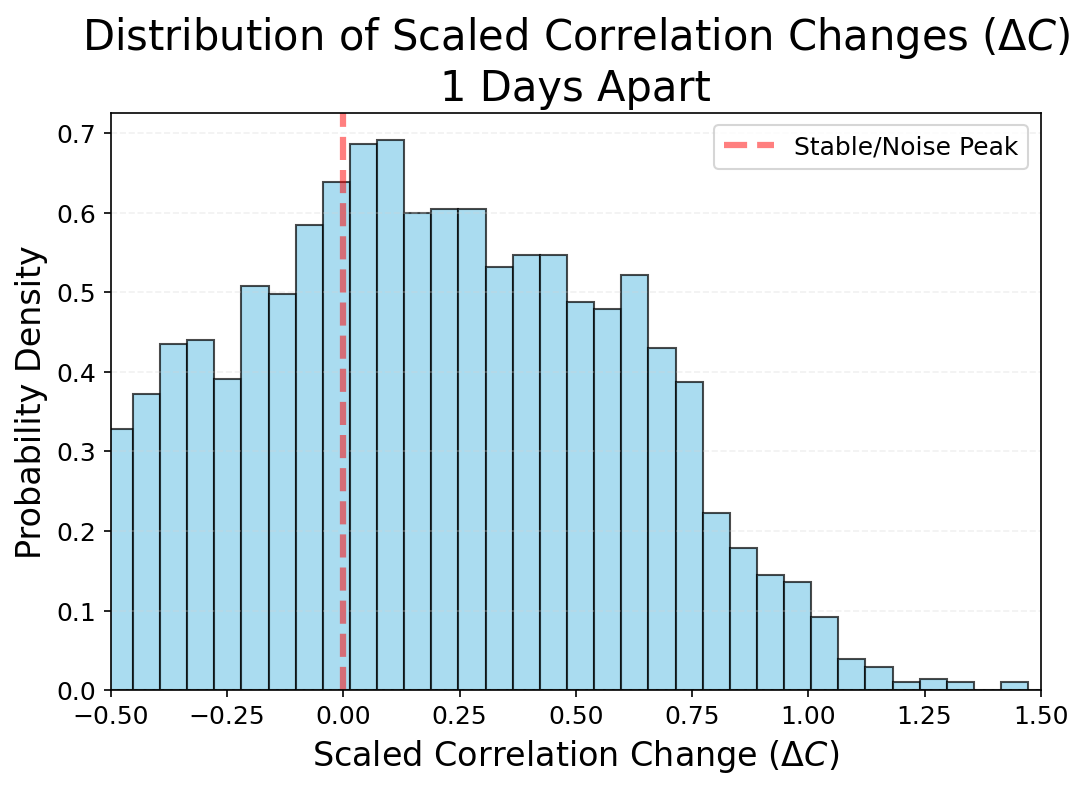

 20%|██        | 4/20 [00:23<01:34,  5.93s/it]

carrying out seed 4


 20%|██        | 4/20 [00:25<01:40,  6.26s/it]


KeyboardInterrupt: 

In [ ]:

Nseed = 10
V_list = np.zeros([4,N,Nseed]) #list of different V vectors for different seeds
all_seed_signatures = []
num_bins = 100
drift_range = (-0.5, 1.5)
for seed in tqdm(range(Nseed)):
    print("carrying out seed " + str(seed))
    
    # initialisation
    np.random.seed(seed)
    r0 = np.zeros(N)
    W0 = np.zeros(N*N)
    exc0 = np.zeros(N)
    theta0 = np.zeros(N)

    # run
    y = run(INPUT)
    exc = y[index[2][:],:]
    r = y[index[0][:],:]
    theta = y[index[3][:],:]

    raw_delta_c = visualise_correlation_change_over_day(1, 0.05, **locals())
    counts, _ = np.histogram(raw_delta_c, bins=num_bins, range=drift_range, density=True)
    
    all_seed_signatures.append(counts)

dataset_matrix = np.array(all_seed_signatures)
np.save('volatility_data_matrix.npy', dataset_matrix)

(1, 100)


# Visualisation Code

#### Transient Firing Rates (heatmap)

The graph plots the firing rates of neurons over time, showing how the activity can drift. The line $np.maximum(0,r)$ just eliminates tiny negatives resulting from floating point errors.

The individual blocks represent different days in the simulation.

The flickers within a block result from the pulse nature of the input.

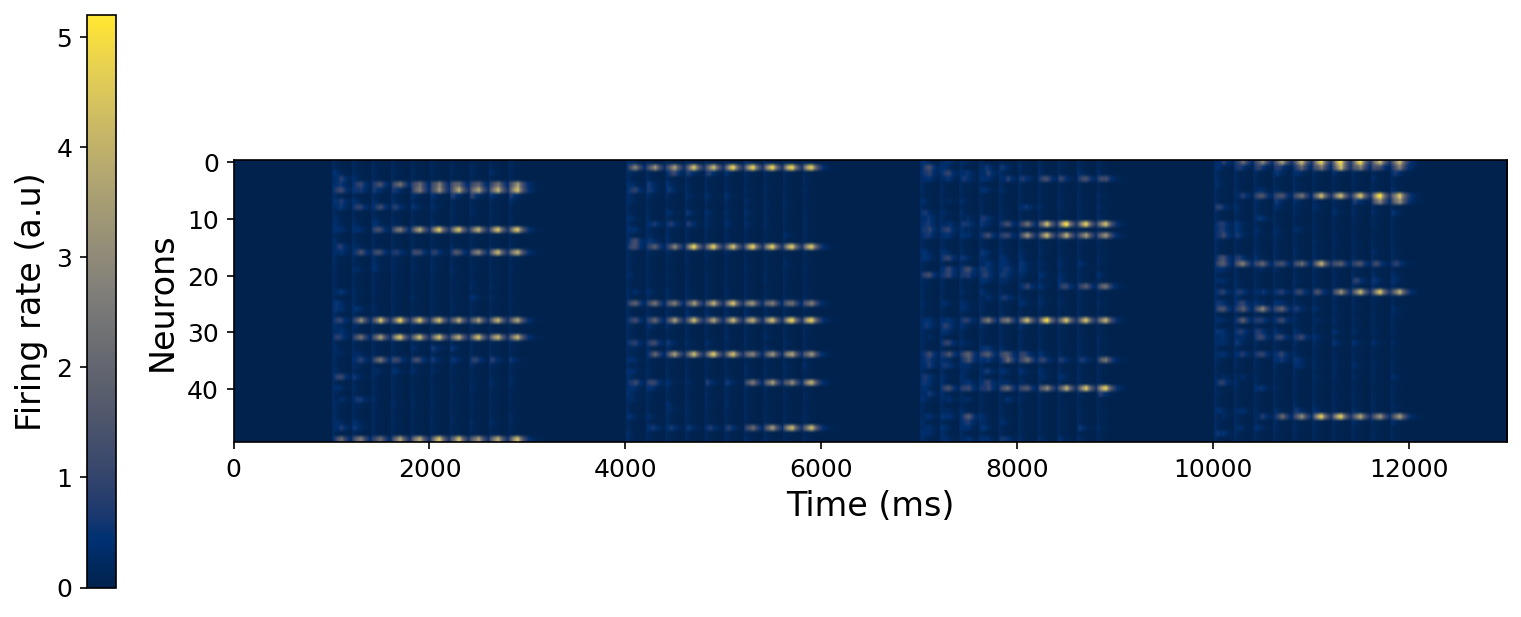

In [9]:
%matplotlib inline
visualise_firing_rates(**locals())

#### Transient Firing Rates (line graph)

This is a medium helpful graph adapted from Delamare et al. By default, the black line represent a 'spaghetti' amalgamation of all the transient firing rates across the experiment, while the red line repsents the same for just a specific selection of neurons.

This is most helpful to examine a specific neurons response in relation to the above heat map but the exact tuning of neurons that show drift likely needs to be changed for each experiment.


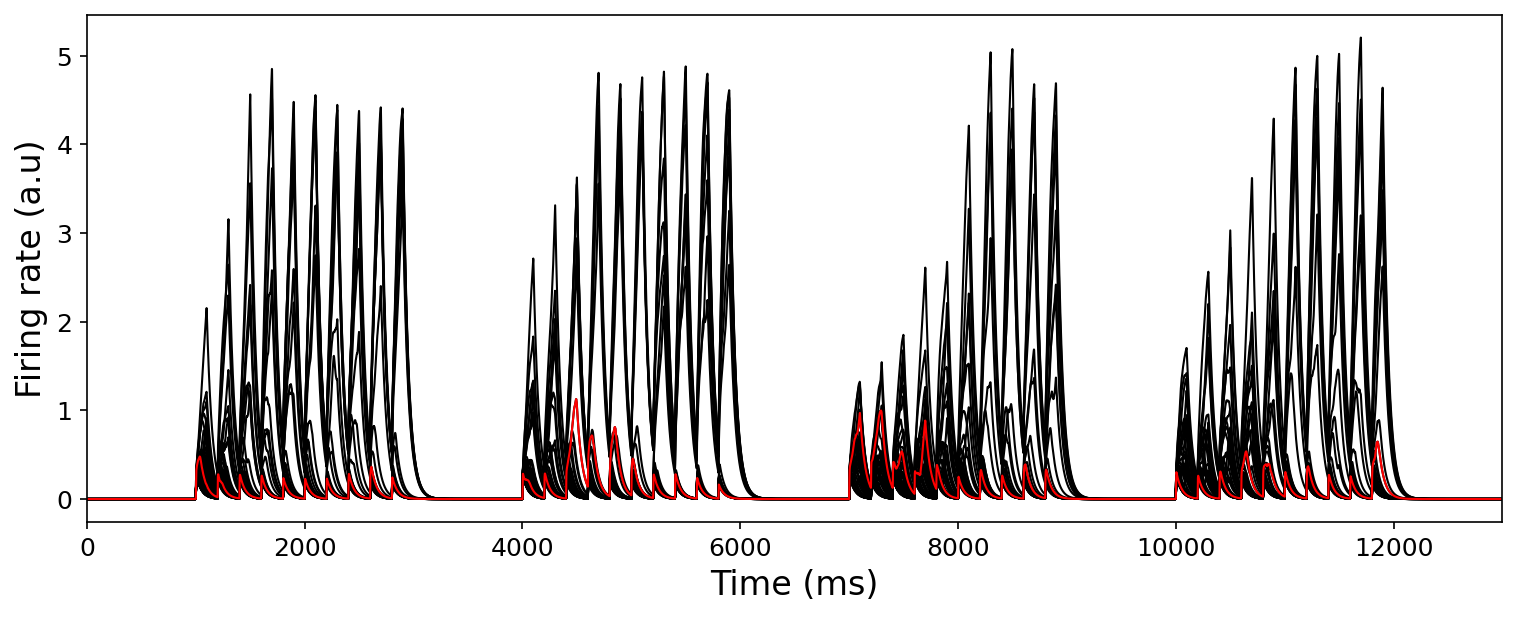

In [10]:
%matplotlib inline
visualise_transient_firing_rates(2,3,**locals())

#### Recurrent Weight Matrix

This shows the reccurrent weights of the network at the end of each day. You should be able to observe a nice drift in the location.

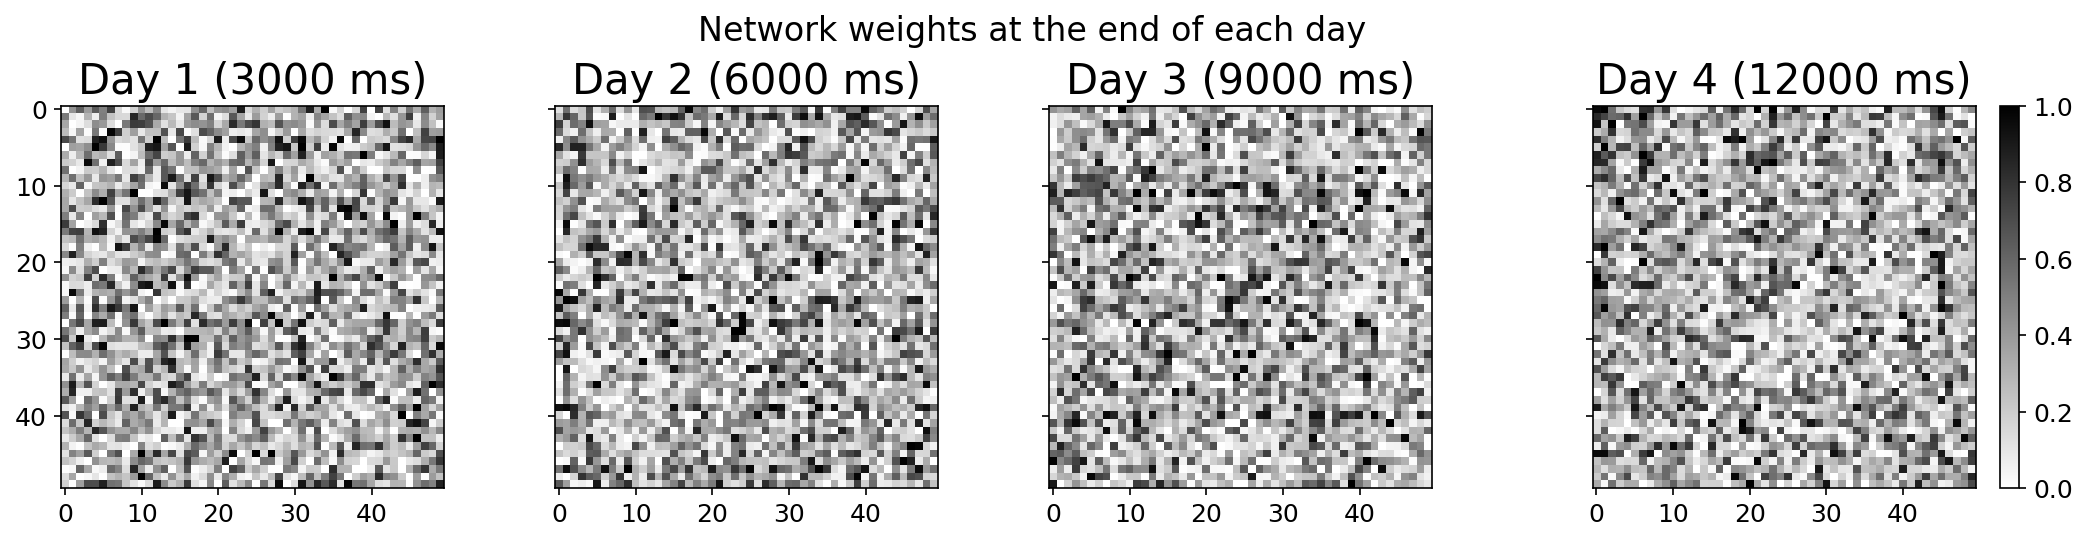

In [11]:
%matplotlib inline
visualise_weight_matrix(**locals())

#### Interactive Visualiser

This is a interactive tool that shows how all aspects of the model evolve with time. It's a bit laggy, at least on my laptop, but helps give a intuiton for the mechanism and hopefully will make understanding future parameter perturbations easier.

IntSlider(value=0, description='Time (ms):', layout=Layout(width='800px'), max=12999, step=100)

Output()

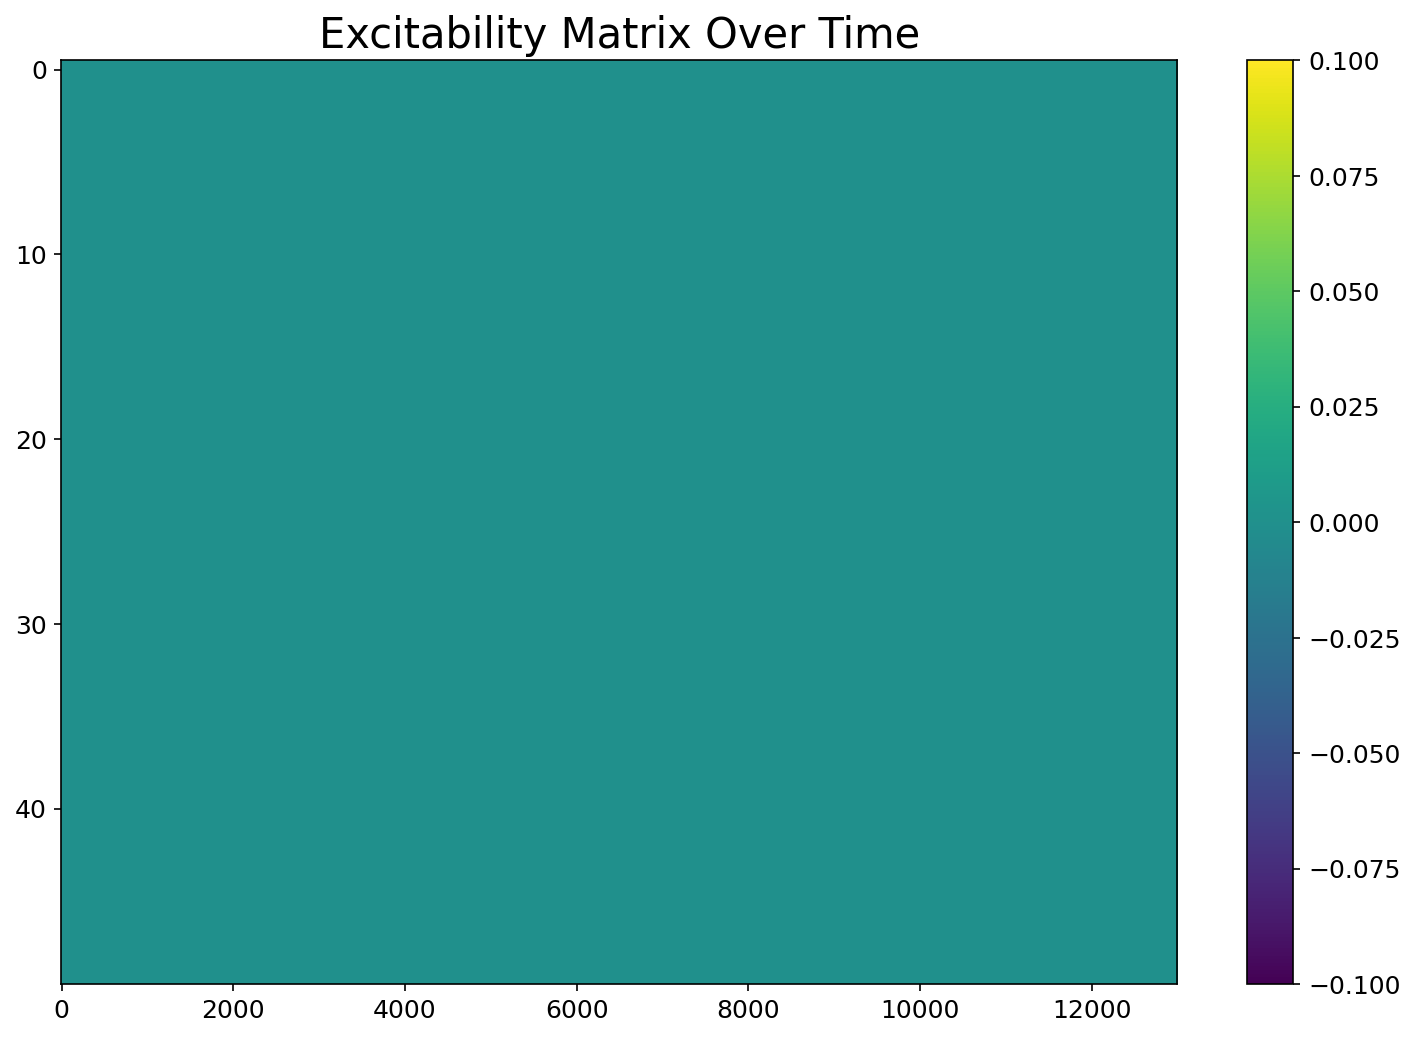

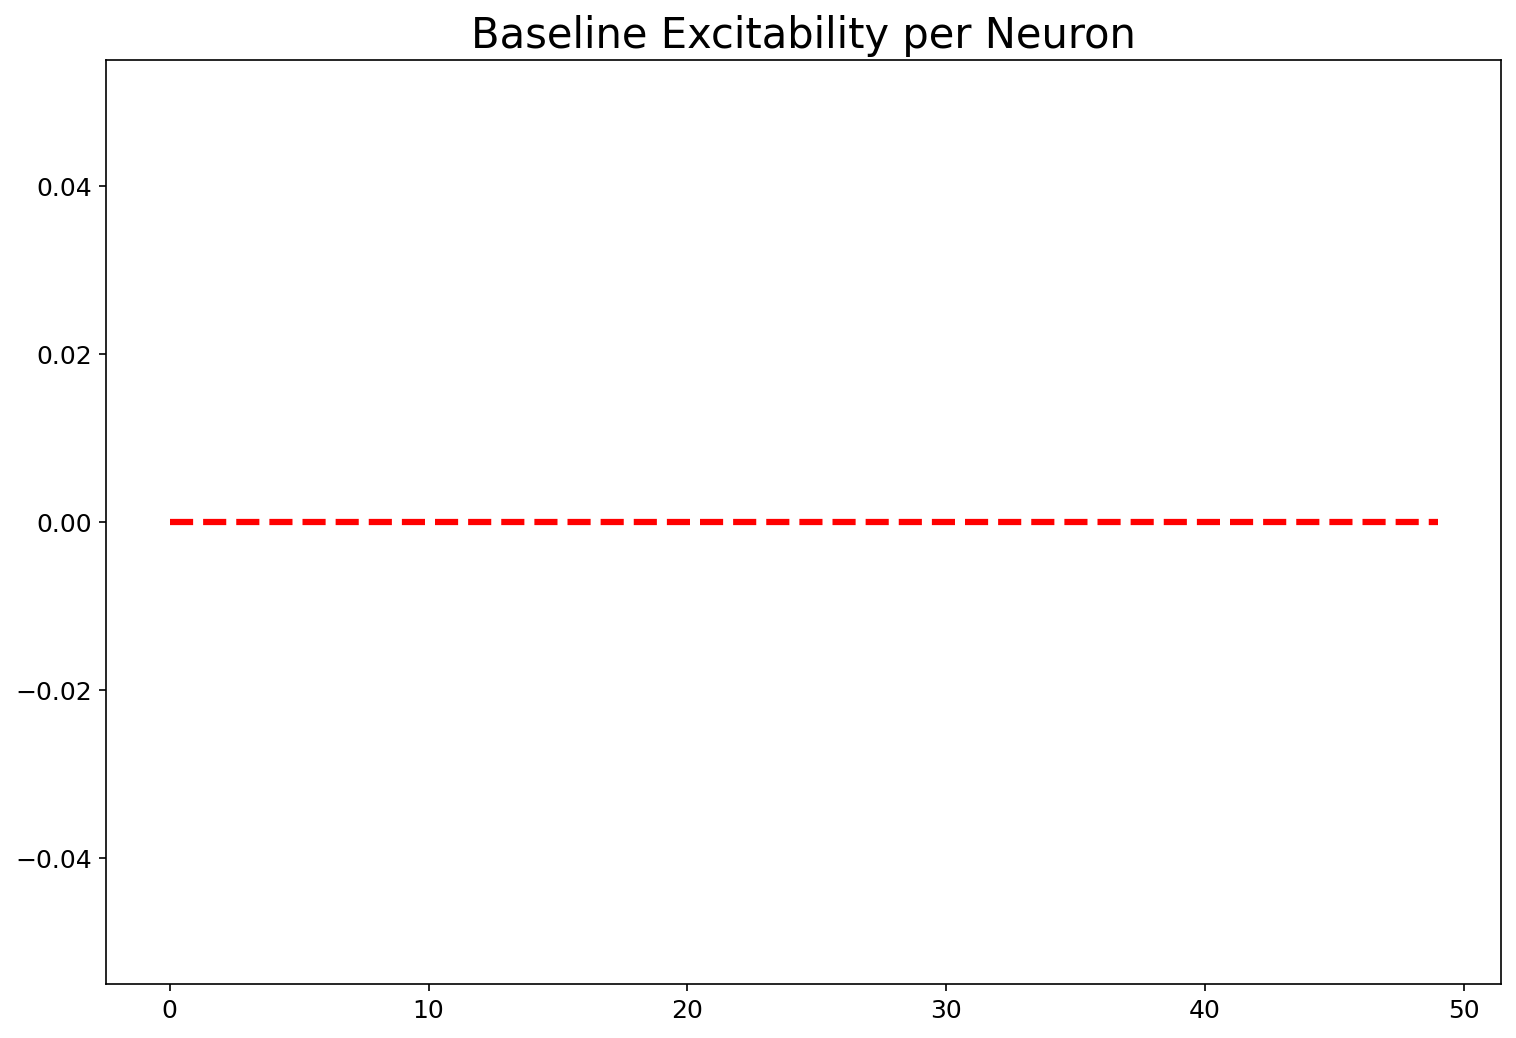

In [12]:
dynamic_visualiser(**locals())
visualise_excitability(**locals())


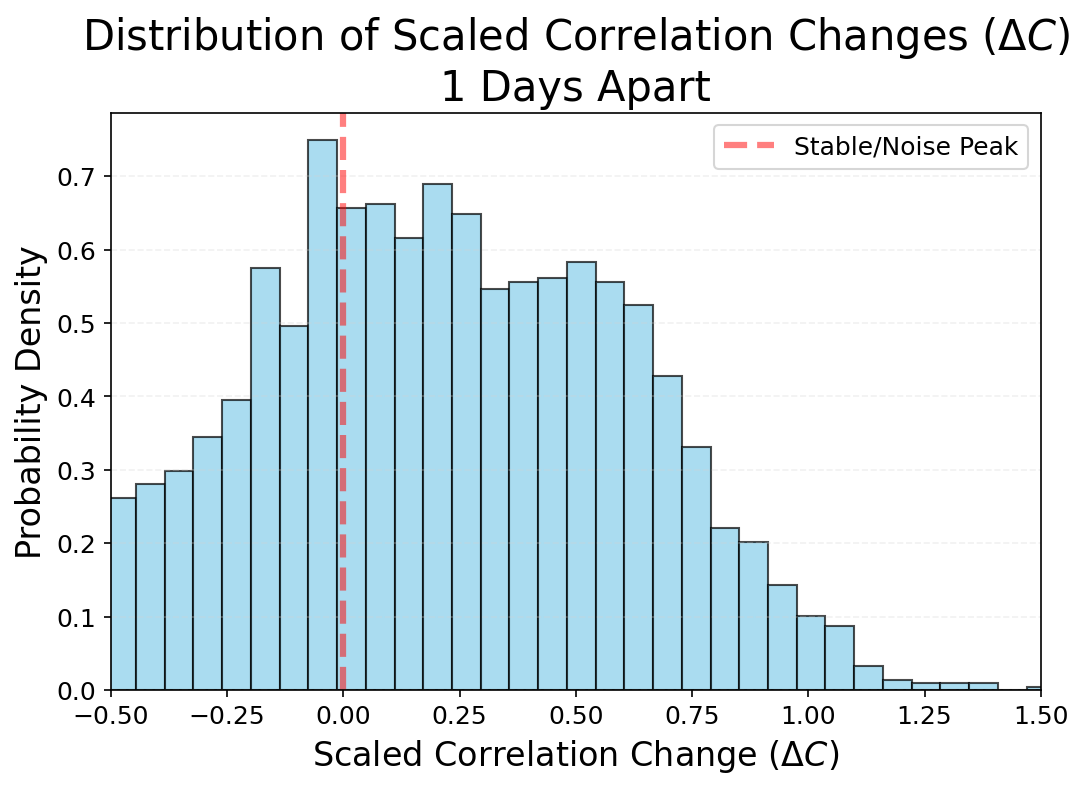

In [13]:
volatility_run = visualise_correlation_change_over_day(1,0.05,**locals())